双路径细粒度识别网络：
1. 全局路径：提取整体特征
2. 局部路径：自动发现2个判别性区域，提取局部特征
3. 自适应融合：动态加权融合全局+局部特征
4. 多粒度监督：主损失 + 辅助损失

In [63]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

def setup_chinese_font():
    """
    设置matplotlib中文字体支持
    返回值: 是否成功设置中文字体
    """
    # 获取可用字体列表
    available_fonts = [f.name for f in mpl.font_manager.fontManager.ttflist]

    # 常见中文字体列表（按优先级排序）
    chinese_fonts = [
        'WenQuanYi Micro Hei',  # Linux常见
        'Microsoft YaHei',      # Windows
        'SimHei',               # Windows
        'SimSun',               # Windows
        'STHeiti',              # Mac
        'STKaiti',              # Mac
        'STSong',               # Mac
        'DejaVu Sans',          # 通用
        'Arial Unicode MS',     # 通用
        'Noto Sans CJK SC',     # Google字体
        'Source Han Sans SC',   # Adobe思源黑体
        'FangSong',             # 仿宋
        'KaiTi',                # 楷体
        'LiSu',                 # 隶书
        'YouYuan'               # 幼圆
    ]

    # 找到第一个可用的中文字体
    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            break

    # 设置字体
    if selected_font:
        try:
            plt.rcParams['font.family'] = [selected_font]
            plt.rcParams['axes.unicode_minus'] = False
            print(f"✅ 中文字体已设置为: {selected_font}")
            return True, selected_font
        except Exception as e:
            print(f"⚠️  字体设置失败: {e}")
            return False, None
    else:
        print("⚠️  警告：未找到合适的中文字体，将使用默认字体")
        return False, None

def set_plot_style(style='default', figsize=(12, 8), dpi=100):
    """
    设置图表样式
    """
    # 设置图表大小和DPI
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['figure.dpi'] = dpi

    # 设置颜色
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
               '#bcbd22', '#17becf']
    )

    # 设置线条和标记
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['axes.linewidth'] = 1.2

    # 设置网格
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.linestyle'] = '--'

    # 设置字体大小
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    # 特殊样式
    if style == 'dark':
        plt.style.use('dark_background')
    elif style == 'seaborn':
        plt.style.use('seaborn-v0_8')
    elif style == 'ggplot':
        plt.style.use('ggplot')

    return True

In [65]:
# ===================== 配置 =====================
MODEL_PATH = "best_flower_finegrained.pth"
METRICS_PATH = "finegrained_metrics.npy"
CLASS_NAMES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
NUM_CLASSES = len(CLASS_NAMES)

# 更小的配置以确保内存安全
BATCH_SIZE = 8
EPOCHS = 25
LEARNING_RATE = 3e-4
IMAGE_SIZE = (224, 224)
NUM_REGIONS = 2

# 损失权重
LAMBDA_GLOBAL = 0.3
LAMBDA_LOCAL = 0.1

In [66]:
def visualize_training_results(train_losses, train_accs, test_losses, test_accs,
                             save_path='fixed_model_training.png',
                             model_name='双路径模型',
                             style='default'):
    """增强的可视化训练结果"""

    # 初始化可视化工具
    setup_chinese_font()
    set_plot_style(style=style, figsize=(12, 4), dpi=100)

    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 绘制损失曲线
    plot_loss_curve(axes[0], train_losses, test_losses, model_name)

    # 绘制准确率曲线
    plot_accuracy_curve(axes[1], train_accs, test_accs, model_name)

    # 保存和显示
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return save_path

# 辅助函数
def plot_loss_curve(ax, train_losses, test_losses, model_name):
    """绘制损失曲线"""
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, 'b-', linewidth=2, label='训练损失')
    ax.plot(epochs, test_losses, 'r-', linewidth=2, label='测试损失')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('损失')
    ax.set_title(f'{model_name}损失曲线')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 添加最终值标签
    if len(train_losses) > 0:
        ax.text(0.98, 0.02, f'最终训练损失: {train_losses[-1]:.4f}',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))
        ax.text(0.98, 0.08, f'最终测试损失: {test_losses[-1]:.4f}',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))

def plot_accuracy_curve(ax, train_accs, test_accs, model_name):
    """绘制准确率曲线"""
    epochs = range(1, len(train_accs) + 1)
    ax.plot(epochs, train_accs, 'g-', linewidth=2, label='训练准确率')
    ax.plot(epochs, test_accs, 'orange', linewidth=2, label='测试准确率')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('准确率')
    ax.set_title(f'{model_name}准确率曲线')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.0)

    # 添加最终值标签
    if len(train_accs) > 0:
        ax.text(0.98, 0.02, f'最终训练准确率: {train_accs[-1]:.4f}',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))
        ax.text(0.98, 0.08, f'最终测试准确率: {test_accs[-1]:.4f}',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))

In [67]:
# ===================== 修复的模型组件 =====================
class FixedRegionProposal(nn.Module):
    """修复的区域提议模块"""
    def __init__(self, in_channels=256, num_regions=2):
        super().__init__()
        self.num_regions = num_regions

        # 简化版注意力生成
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_regions, kernel_size=1),
        )

    def forward(self, x):
        # x: [B, C, H, W]
        attention_logits = self.conv(x)  # [B, num_regions, H, W]
        attention_maps = F.softmax(attention_logits, dim=1)
        return attention_maps


class FixedLocalEncoder(nn.Module):
    """修复的局部特征编码器"""
    def __init__(self, output_dim=256):
        super().__init__()

        # 更小的卷积网络
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        )

        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        # x: [B, 3, H, W]
        features = self.feature_extractor(x)  # [B, 128, 1, 1]
        features = features.view(features.size(0), -1)  # [B, 128]
        encoded = self.fc(features)  # [B, output_dim]
        return encoded


class FixedFusionModule(nn.Module):
    """修复的特征融合模块"""
    def __init__(self, global_dim=512, local_dim=256, num_regions=2):
        super().__init__()
        self.num_regions = num_regions

        # 特征投影
        self.global_proj = nn.Linear(global_dim, 128)
        self.local_proj = nn.Linear(local_dim, 128)

        # 权重生成
        self.weight_net = nn.Sequential(
            nn.Linear(128 * (1 + num_regions), 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 1 + num_regions),
            nn.Softmax(dim=1)
        )

    def forward(self, global_feat, local_feats):
        batch_size = global_feat.size(0)

        # 投影到统一维度
        global_proj = self.global_proj(global_feat)
        local_projs = [self.local_proj(feat) for feat in local_feats]

        # 生成融合权重
        all_feats = [global_proj] + local_projs
        concat_feats = torch.cat(all_feats, dim=1)
        weights = self.weight_net(concat_feats)

        # 加权融合
        fused = global_proj * weights[:, 0:1]
        for i in range(self.num_regions):
            fused = fused + local_projs[i] * weights[:, i+1:i+2]

        return fused, weights



In [68]:
# ===================== 修复的完整模型 =====================
class FixedDualPathModel(nn.Module):
    """修复的双路径模型"""
    def __init__(self, num_classes=5, num_regions=2):
        super().__init__()
        self.num_regions = num_regions

        # ========== 骨干网络 ==========
        # 使用resnet18，但只使用特征提取部分
        backbone = models.resnet18(pretrained=True)

        # 提取中间层特征用于区域提议
        self.layer1 = nn.Sequential(*list(backbone.children())[:5])  # 到layer1
        self.layer2 = backbone.layer2  # layer2

        # 全局特征提取器（layer3和layer4）
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # ========== 区域提议 ==========
        # layer2的输出通道数：128（对于resnet18）
        self.region_proposal = FixedRegionProposal(
            in_channels=128,  # layer2的输出通道
            num_regions=num_regions
        )

        # ========== 局部编码器 ==========
        self.local_encoder = FixedLocalEncoder(output_dim=256)

        # ========== 特征融合 ==========
        # layer4的输出通道数：512（对于resnet18）
        self.fusion = FixedFusionModule(
            global_dim=512,  # layer4的输出
            local_dim=256,   # 局部编码器输出
            num_regions=num_regions
        )

        # ========== 分类器 ==========
        # 全局分类器
        self.global_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # 最终分类器
        self.final_classifier = nn.Sequential(
            nn.Linear(128, 64),  # 融合特征维度是128
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

        # 冻结骨干网络的前面部分
        for param in self.layer1.parameters():
            param.requires_grad = False
        for param in self.layer2.parameters():
            param.requires_grad = False

    def forward(self, x, return_attention=False):
        batch_size = x.size(0)

        # ========== 特征提取 ==========
        # layer1和layer2（用于区域提议）
        with torch.no_grad():
            feat1 = self.layer1(x)      # [B, 64, 56, 56]
            feat2 = self.layer2(feat1)  # [B, 128, 28, 28] - 用于区域提议

            # layer3和layer4（全局特征）
            feat3 = self.layer3(feat2)  # [B, 256, 14, 14]
            feat4 = self.layer4(feat3)  # [B, 512, 7, 7] - 全局特征

        # 全局特征
        global_pooled = self.global_pool(feat4)
        global_feat = global_pooled.view(batch_size, -1)  # [B, 512]

        # ========== 区域提议 ==========
        attention_maps = self.region_proposal(feat2)  # [B, num_regions, 28, 28]

        # 上采样注意力图
        attention_maps_full = F.interpolate(
            attention_maps, size=x.shape[2:],
            mode='bilinear', align_corners=False
        )  # [B, num_regions, H, W]

        # ========== 局部特征提取 ==========
        local_feats = []
        for i in range(self.num_regions):
            # 获取当前区域的注意力图
            region_mask = attention_maps_full[:, i:i+1]  # [B, 1, H, W]

            # 应用注意力到输入图像
            region_input = x * region_mask

            # 提取局部特征
            local_feat = self.local_encoder(region_input)  # [B, 256]
            local_feats.append(local_feat)

        # ========== 特征融合 ==========
        fused_feature, fusion_weights = self.fusion(global_feat, local_feats)  # [B, 128]

        # ========== 分类输出 ==========
        global_logits = self.global_classifier(global_feat)
        final_logits = self.final_classifier(fused_feature)

        outputs = {
            'final_logits': final_logits,
            'global_logits': global_logits,
            'fused_feature': fused_feature,
            'fusion_weights': fusion_weights,
            'attention_maps': attention_maps_full,
            'global_feature': global_feat
        }

        if return_attention:
            return outputs, attention_maps_full
        return outputs

    def compute_loss(self, outputs, labels, criterion):
        """计算多任务损失"""
        loss_final = criterion(outputs['final_logits'], labels)
        loss_global = criterion(outputs['global_logits'], labels)

        total_loss = loss_final + LAMBDA_GLOBAL * loss_global

        loss_details = {
            'loss_final': loss_final.item(),
            'loss_global': loss_global.item(),
            'total_loss': total_loss.item()
        }

        return total_loss, loss_details



In [69]:
# ===================== 训练函数 =====================
def train_fixed_model(device):
    """训练修复的模型"""
    import gc

    print(f"\n🚀 开始训练修复的双路径模型...")

    # 清理缓存
    torch.cuda.empty_cache()
    gc.collect()

    # 加载数据
    BASE_DIR = "flowers"
    TRAIN_DIR = os.path.join(BASE_DIR, "train")
    TEST_DIR = os.path.join(BASE_DIR, "test")

    # 数据变换
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    print(f"训练集: {len(train_dataset)} 样本")
    print(f"测试集: {len(test_dataset)} 样本")
    print(f"批次大小: {BATCH_SIZE}")

    # 构建模型
    print(f"\n🔧 构建模型...")
    model = FixedDualPathModel(
        num_classes=NUM_CLASSES,
        num_regions=NUM_REGIONS
    )
    model = model.to(device)

    # 统计可训练参数
    trainable_params = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params.append(param)

    print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
    print(f"可训练参数量: {sum(p.numel() for p in trainable_params):,}")
    print(f"冻结参数量: {sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in trainable_params):,}")

    # 优化器
    optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

    # 损失函数
    criterion = nn.CrossEntropyLoss()

    # 训练指标
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_test_acc = 0.0

    print(f"\n📈 开始训练，共 {EPOCHS} 个epoch...")

    for epoch in range(EPOCHS):
        # ===== 训练阶段 =====
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        fusion_stats = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for batch_idx, (images, labels) in enumerate(pbar):
            # 定期清理缓存
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()

            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)

            # 计算损失
            loss, loss_details = model.compute_loss(outputs, labels, criterion)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)

            optimizer.step()

            # 统计
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs['final_logits'], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 收集融合权重统计
            fusion_stats.append(outputs['fusion_weights'].mean(dim=0).cpu().detach().numpy())

            # 更新进度条
            if len(fusion_stats) > 0:
                avg_fusion = np.mean(fusion_stats[-5:], axis=0)
                fusion_str = f"G:{avg_fusion[0]:.2f}"
                for i in range(NUM_REGIONS):
                    fusion_str += f", L{i+1}:{avg_fusion[i+1]:.2f}"
            else:
                fusion_str = ""

            pbar.set_postfix({
                "loss": running_loss / max(total, 1),
                "acc": correct / max(total, 1),
                "fusion": fusion_str[:20]  # 限制显示长度
            })

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # ===== 验证阶段 =====
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs['final_logits'], labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs['final_logits'], 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar.set_postfix({
                    "loss": running_loss / max(total, 1),
                    "acc": correct / max(total, 1)
                })

        test_loss = running_loss / len(test_loader.dataset)
        test_acc = correct / total

        # 学习率调整
        scheduler.step()

        # 记录指标
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # 打印结果
        print(f"\n📊 Epoch {epoch+1} 结果:")
        print(f"  训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
        print(f"  测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}")
        print(f"  学习率: {optimizer.param_groups[0]['lr']:.6f}")

        if fusion_stats:
            avg_fusion = np.mean(fusion_stats, axis=0)
            print(f"  平均融合权重 - 全局: {avg_fusion[0]:.3f}, ", end="")
            for i in range(NUM_REGIONS):
                print(f"局部{i+1}: {avg_fusion[i+1]:.3f}", end=", " if i < NUM_REGIONS-1 else "")
            print()

        # 保存最优模型
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_test_acc': best_test_acc,
                'config': {
                    'model_type': 'fixed_dual_path',
                    'num_regions': NUM_REGIONS,
                    'image_size': IMAGE_SIZE,
                    'batch_size': BATCH_SIZE
                }
            }, MODEL_PATH)
            print(f"  💾 保存最优模型，准确率: {best_test_acc:.4f}")

    # 保存训练指标
    metrics = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_test_acc': best_test_acc,
        'epochs': EPOCHS
    }
    np.save(METRICS_PATH, metrics)

    print(f"\n✅ 训练完成!")
    print(f"最佳测试准确率: {best_test_acc:.4f}")

    # 可视化结果
    visualize_training_results(train_losses, train_accs, test_losses, test_accs)

    return model, test_loader



In [70]:
# ===================== 测试函数 =====================
def test_fixed_model(device):
    """测试修复的模型"""
    if not os.path.exists(MODEL_PATH):
        print(f"错误: 找不到模型文件 {MODEL_PATH}")
        print("请先训练模型！")
        return

    print(f"\n🧪 测试修复的双路径模型...")

    # 加载数据
    BASE_DIR = "flowers"
    TEST_DIR = os.path.join(BASE_DIR, "test")

    test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # 构建模型
    model = FixedDualPathModel(
        num_classes=NUM_CLASSES,
        num_regions=NUM_REGIONS
    )
    model = model.to(device)

    # 加载权重
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 测试评估
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    all_fusion_weights = []

    print(f"开始测试...")

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="测试中")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # 收集融合权重
            all_fusion_weights.append(outputs['fusion_weights'].cpu())

            # 计算损失
            loss = criterion(outputs['final_logits'], labels)

            # 统计指标
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs['final_logits'], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label, pred in zip(labels.cpu(), predicted.cpu()):
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

            pbar.set_postfix({
                "acc": correct / max(total, 1)
            })

    # 计算最终指标
    final_loss = running_loss / len(test_loader.dataset)
    final_acc = correct / total

    # 分析融合权重
    if len(all_fusion_weights) > 0: 
        all_fusion_weights = torch.cat(all_fusion_weights, dim=0)
        avg_weights = all_fusion_weights.mean(dim=0).numpy()
    else:
        avg_weights = None
    print(f"\n📈 测试结果:")
    print(f"整体测试损失: {final_loss:.4f}")
    print(f"整体测试准确率: {final_acc:.4f}")
    print(f"最佳历史准确率: {checkpoint['best_test_acc']:.4f}")

    if len(all_fusion_weights) > 0: 
        print(f"\n🔍 融合权重分析:")
        print(f"全局特征权重: {avg_weights[0]:.3f}")
        for i in range(NUM_REGIONS):
            print(f"局部特征{i+1}权重: {avg_weights[i+1]:.3f}")

    print(f"\n📊 各类别准确率:")
    for i in range(NUM_CLASSES):
        acc = class_correct[i] / max(class_total[i], 1)
        print(f"{CLASS_NAMES[i]}: {acc:.4f} ({class_correct[i]}/{class_total[i]})")

    # 可视化注意力图示例
    visualize_sample_attention(model, test_loader, device)


In [71]:
def visualize_sample_attention(model, test_loader, device, num_samples=3):
    """可视化样本注意力图 - 模块化版本"""

    # 初始化可视化设置
    setup_chinese_font()
    set_plot_style(figsize=(15, 3*num_samples), dpi=100)

    # 获取数据和预测
    images, labels, outputs, attention_maps = get_attention_data(
        model, test_loader, device, num_samples
    )

    # 创建可视化图表
    fig = create_attention_figure(
        images, labels, outputs, attention_maps, num_samples
    )

    # 保存和显示
    save_and_show_figure(fig, 'attention_visualization.png')

    return fig

# ==================== 辅助函数 ====================

def get_attention_data(model, test_loader, device, num_samples):
    """获取注意力相关数据"""
    model.eval()

    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images[:num_samples].to(device)
        labels = labels[:num_samples]

        outputs, attention_maps = model(images, return_attention=True)

    return images, labels, outputs, attention_maps

def denormalize_image(tensor):
    """反归一化图像显示"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = tensor.clamp(0, 1)
    return tensor.permute(1, 2, 0).numpy()

def create_attention_figure(images, labels, outputs, attention_maps, num_samples):
    """创建注意力可视化图表"""
    fig, axes = plt.subplots(
        num_samples, NUM_REGIONS + 2,
        figsize=(15, 3 * num_samples)
    )

    # 确保axes总是二维数组
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # 原始图像
        plot_original_image(axes[i, 0], images[i], labels[i])

        # 注意力图
        for j in range(NUM_REGIONS):
            plot_attention_map(axes[i, j+1], attention_maps[i, j],
                             outputs['fusion_weights'][i, j+1], j)

        # 融合权重
        plot_fusion_weights(axes[i, -1], outputs['fusion_weights'][i])

    plt.suptitle('双路径模型注意力可视化', fontsize=14)
    plt.tight_layout()

    return fig

def plot_original_image(ax, image_tensor, label):
    """绘制原始图像"""
    img = denormalize_image(image_tensor.cpu())
    ax.imshow(img)
    ax.set_title(f"原始\n{CLASS_NAMES[label]}")
    ax.axis('off')

def plot_attention_map(ax, attention_map, weight, region_idx):
    """绘制注意力图"""
    att_map = attention_map.cpu().numpy()
    ax.imshow(att_map, cmap='hot')
    ax.set_title(f"区域{region_idx+1}\nw={weight.item():.2f}")
    ax.axis('off')

def plot_fusion_weights(ax, weights_tensor):
    """绘制融合权重柱状图"""
    weights = weights_tensor.cpu().numpy()
    ax.bar(range(len(weights)), weights, color=['blue', 'green', 'red'][:len(weights)])
    ax.set_title("融合权重")
    ax.set_xticks(range(len(weights)))
    ax.set_xticklabels(['全局'] + [f'局部{i+1}' for i in range(len(weights)-1)])
    ax.set_ylim(0, 1.0)

def save_and_show_figure(fig, filename):
    """保存和显示图表"""
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ 注意力可视化已保存为: {filename}")

设备: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
内存: 8.18 GB

修复版双路径花卉分类模型
配置:
  骨干网络: ResNet18
  局部区域数: 2
  批次大小: 8
  训练轮数: 25

请选择模式:
1. 训练模型
2. 测试模型

🧪 测试修复的双路径模型...
开始测试...


测试中: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s, acc=0.799]



📈 测试结果:
整体测试损失: 0.7369
整体测试准确率: 0.7991
最佳历史准确率: 0.7991

🔍 融合权重分析:
全局特征权重: 0.961
局部特征1权重: 0.008
局部特征2权重: 0.030

📊 各类别准确率:
daisy: 0.7597 (98/129)
dandelion: 0.8767 (199/227)
rose: 0.6154 (56/91)
sunflower: 0.6707 (55/82)
tulip: 0.9187 (113/123)
✅ 中文字体已设置为: WenQuanYi Micro Hei


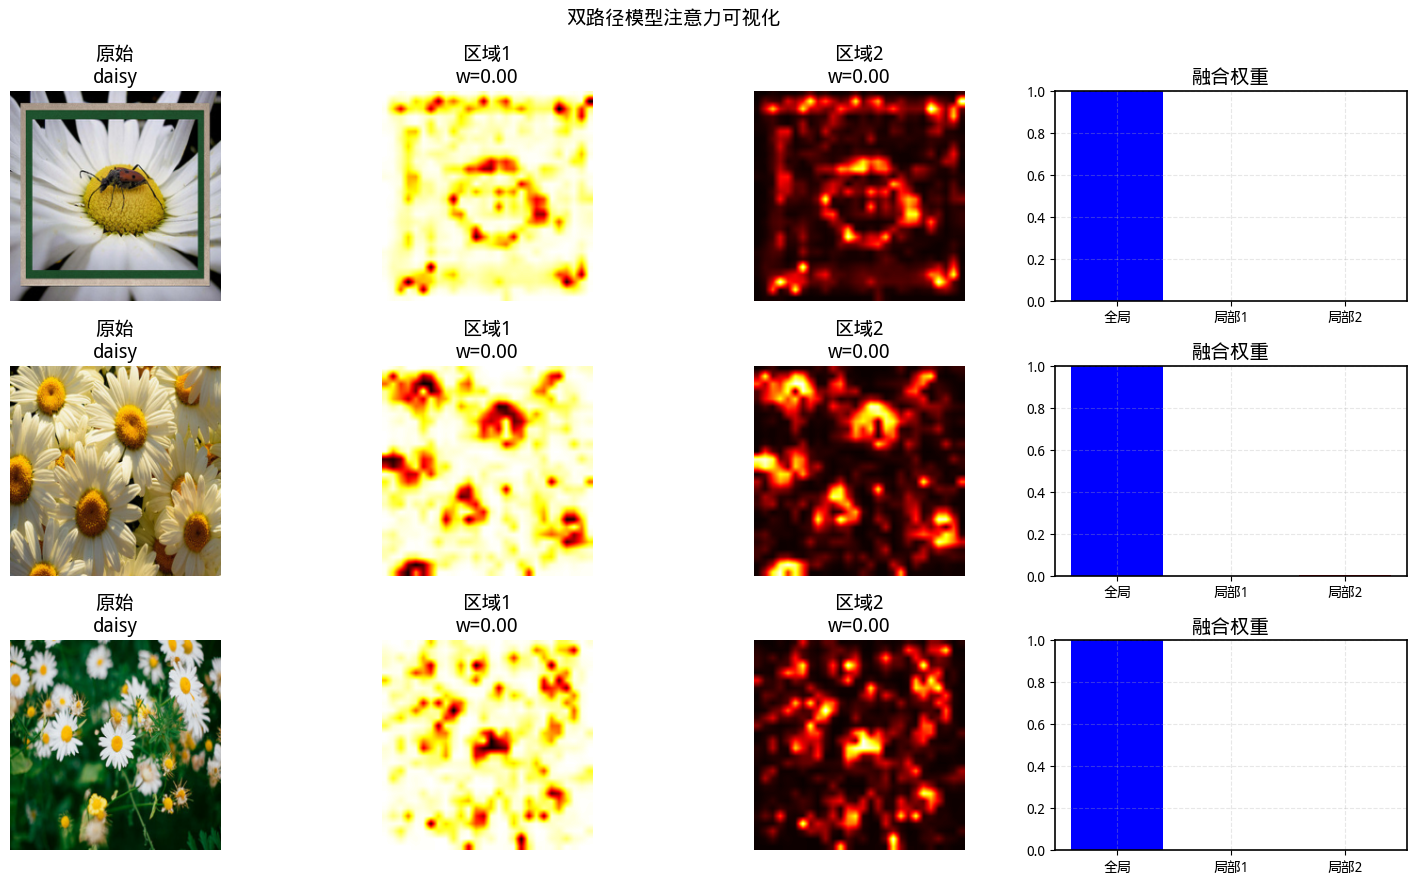

✅ 注意力可视化已保存为: attention_visualization.png

✅ 程序执行完成


In [72]:
if __name__ == '__main__':
    # 设备检查
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"设备: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    print("\n" + "="*60)
    print("修复版双路径花卉分类模型")
    print("="*60)
    print(f"配置:")
    print(f"  骨干网络: ResNet18")
    print(f"  局部区域数: {NUM_REGIONS}")
    print(f"  批次大小: {BATCH_SIZE}")
    print(f"  训练轮数: {EPOCHS}")
    print("="*60)

    # 模式选择
    print("\n请选择模式:")
    print("1. 训练模型")
    print("2. 测试模型")

    try:
        choice = input("输入选择 (1/2): ").strip()
    except:
        choice = '1'

    try:
        if choice == '1':
            model, test_loader = train_fixed_model(device)

            # 测试训练好的模型
            print("\n" + "="*60)
            print("测试训练好的模型...")
            print("="*60)
            test_fixed_model(device)

        elif choice == '2':
            test_fixed_model(device)

    except Exception as e:
        print(f"\n❌ 错误发生: {e}")
        print("\n建议:")
        print("1. 确保 'flowers' 文件夹存在且数据完整")
        print("2. 尝试进一步减小 BATCH_SIZE")
        print("3. 检查CUDA和PyTorch版本")

        import traceback
        traceback.print_exc()

    print("\n✅ 程序执行完成")